In [2]:
# This UNET-style prediction model was originally included as part of the Score-based generative modelling tutorial 
# by Yang Song et al: https://colab.research.google.com/drive/120kYYBOVa1i0TD85RjlEkFjaWDxSFUx3?usp=sharing

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torchvision import datasets, transforms, utils
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import math
from torchvision.models import inception_v3
from torchvision import utils
from scipy import linalg
from tqdm.auto import tqdm
from typing import Dict, List, Optional, Tuple

class GaussianFourierProjection(nn.Module):
  """Gaussian random features for encoding time steps."""  
  def __init__(self, embed_dim, scale=30.):
    super().__init__()
    # Randomly sample weights during initialization. These weights are fixed 
    # during optimization and are not trainable.
    self.W = nn.Parameter(torch.randn(embed_dim // 2) * scale, requires_grad=False)
  def forward(self, x):
    x_proj = x[:, None] * self.W[None, :] * 2 * np.pi
    return torch.cat([torch.sin(x_proj), torch.cos(x_proj)], dim=-1)


class Dense(nn.Module):
  """A fully connected layer that reshapes outputs to feature maps."""
  def __init__(self, input_dim, output_dim):
    super().__init__()
    self.dense = nn.Linear(input_dim, output_dim)
  def forward(self, x):
    return self.dense(x)[..., None, None]


class ScoreNet(nn.Module):
  """A time-dependent score-based model built upon U-Net architecture."""

  def __init__(self, marginal_prob_std, channels=[32, 64, 128, 256], embed_dim=256):
    """Initialize a time-dependent score-based network.

    Args:
      marginal_prob_std: A function that takes time t and gives the standard
        deviation of the perturbation kernel p_{0t}(x(t) | x(0)).
      channels: The number of channels for feature maps of each resolution.
      embed_dim: The dimensionality of Gaussian random feature embeddings.
    """
    super().__init__()
    # Gaussian random feature embedding layer for time
    self.embed = nn.Sequential(GaussianFourierProjection(embed_dim=embed_dim),
         nn.Linear(embed_dim, embed_dim))
    # Encoding layers where the resolution decreases
    self.conv1 = nn.Conv2d(1, channels[0], 3, stride=1, bias=False)
    self.dense1 = Dense(embed_dim, channels[0])
    self.gnorm1 = nn.GroupNorm(4, num_channels=channels[0])
    self.conv2 = nn.Conv2d(channels[0], channels[1], 3, stride=2, bias=False)
    self.dense2 = Dense(embed_dim, channels[1])
    self.gnorm2 = nn.GroupNorm(32, num_channels=channels[1])
    self.conv3 = nn.Conv2d(channels[1], channels[2], 3, stride=2, bias=False)
    self.dense3 = Dense(embed_dim, channels[2])
    self.gnorm3 = nn.GroupNorm(32, num_channels=channels[2])
    self.conv4 = nn.Conv2d(channels[2], channels[3], 3, stride=2, bias=False)
    self.dense4 = Dense(embed_dim, channels[3])
    self.gnorm4 = nn.GroupNorm(32, num_channels=channels[3])    

    # Decoding layers where the resolution increases
    self.tconv4 = nn.ConvTranspose2d(channels[3], channels[2], 3, stride=2, bias=False)
    self.dense5 = Dense(embed_dim, channels[2])
    self.tgnorm4 = nn.GroupNorm(32, num_channels=channels[2])
    self.tconv3 = nn.ConvTranspose2d(channels[2] + channels[2], channels[1], 3, stride=2, bias=False, output_padding=1)    
    self.dense6 = Dense(embed_dim, channels[1])
    self.tgnorm3 = nn.GroupNorm(32, num_channels=channels[1])
    self.tconv2 = nn.ConvTranspose2d(channels[1] + channels[1], channels[0], 3, stride=2, bias=False, output_padding=1)    
    self.dense7 = Dense(embed_dim, channels[0])
    self.tgnorm2 = nn.GroupNorm(32, num_channels=channels[0])
    self.tconv1 = nn.ConvTranspose2d(channels[0] + channels[0], 1, 3, stride=1)
    
    # The swish activation function
    self.act = lambda x: x * torch.sigmoid(x)
    self.marginal_prob_std = marginal_prob_std
  
  def forward(self, x, t): 
    # Obtain the Gaussian random feature embedding for t   
    embed = self.act(self.embed(t))    
    # Encoding path
    h1 = self.conv1(x)    
    ## Incorporate information from t
    h1 += self.dense1(embed)
    ## Group normalization
    h1 = self.gnorm1(h1)
    h1 = self.act(h1)
    h2 = self.conv2(h1)
    h2 += self.dense2(embed)
    h2 = self.gnorm2(h2)
    h2 = self.act(h2)
    h3 = self.conv3(h2)
    h3 += self.dense3(embed)
    h3 = self.gnorm3(h3)
    h3 = self.act(h3)
    h4 = self.conv4(h3)
    h4 += self.dense4(embed)
    h4 = self.gnorm4(h4)
    h4 = self.act(h4)

    # Decoding path
    h = self.tconv4(h4)
    ## Skip connection from the encoding path
    h += self.dense5(embed)
    h = self.tgnorm4(h)
    h = self.act(h)
    h = self.tconv3(torch.cat([h, h3], dim=1))
    h += self.dense6(embed)
    h = self.tgnorm3(h)
    h = self.act(h)
    h = self.tconv2(torch.cat([h, h2], dim=1))
    h += self.dense7(embed)
    h = self.tgnorm2(h)
    h = self.act(h)
    h = self.tconv1(torch.cat([h, h1], dim=1))

    # Normalize output
    h = h / self.marginal_prob_std(t)[:, None, None, None]
    return h

In [3]:
# ExponentialMovingAverage implementation as used in pytorch vision
# https://github.com/pytorch/vision/blob/main/references/classification/utils.py#L159

# BSD 3-Clause License

# Copyright (c) Soumith Chintala 2016, 
# All rights reserved.

# Redistribution and use in source and binary forms, with or without
# modification, are permitted provided that the following conditions are met:

# * Redistributions of source code must retain the above copyright notice, this
#   list of conditions and the following disclaimer.

# * Redistributions in binary form must reproduce the above copyright notice,
#   this list of conditions and the following disclaimer in the documentation
#   and/or other materials provided with the distribution.

# * Neither the name of the copyright holder nor the names of its
#   contributors may be used to endorse or promote products derived from
#   this software without specific prior written permission.

# THIS SOFTWARE IS PROVIDED BY THE COPYRIGHT HOLDERS AND CONTRIBUTORS "AS IS"
# AND ANY EXPRESS OR IMPLIED WARRANTIES, INCLUDING, BUT NOT LIMITED TO, THE
# IMPLIED WARRANTIES OF MERCHANTABILITY AND FITNESS FOR A PARTICULAR PURPOSE ARE
# DISCLAIMED. IN NO EVENT SHALL THE COPYRIGHT HOLDER OR CONTRIBUTORS BE LIABLE
# FOR ANY DIRECT, INDIRECT, INCIDENTAL, SPECIAL, EXEMPLARY, OR CONSEQUENTIAL
# DAMAGES (INCLUDING, BUT NOT LIMITED TO, PROCUREMENT OF SUBSTITUTE GOODS OR
# SERVICES; LOSS OF USE, DATA, OR PROFITS; OR BUSINESS INTERRUPTION) HOWEVER
# CAUSED AND ON ANY THEORY OF LIABILITY, WHETHER IN CONTRACT, STRICT LIABILITY,
# OR TORT (INCLUDING NEGLIGENCE OR OTHERWISE) ARISING IN ANY WAY OUT OF THE USE
# OF THIS SOFTWARE, EVEN IF ADVISED OF THE POSSIBILITY OF SUCH DAMAGE.
    
class ExponentialMovingAverage(torch.optim.swa_utils.AveragedModel):
    """Maintains moving averages of model parameters using an exponential decay.
    ``ema_avg = decay * avg_model_param + (1 - decay) * model_param``
    `torch.optim.swa_utils.AveragedModel <https://pytorch.org/docs/stable/optim.html#custom-averaging-strategies>`_
    is used to compute the EMA.
    """

    def __init__(self, model, decay, device="cpu"):
        def ema_avg(avg_model_param, model_param, num_averaged):
            return decay * avg_model_param + (1 - decay) * model_param

        super().__init__(model, device, ema_avg, use_buffers=True)

Training:   0%|          | 0/23500 [00:00<?, ?it/s]

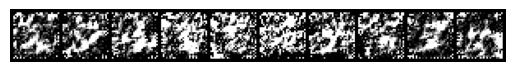

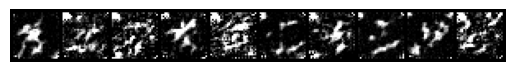

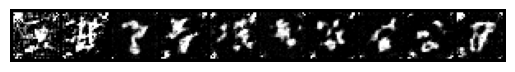

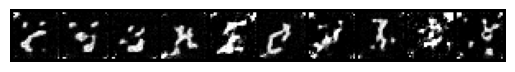

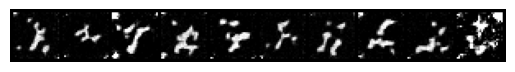

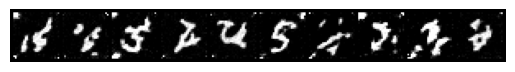

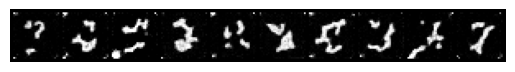

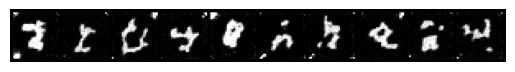

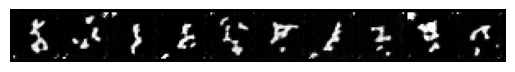

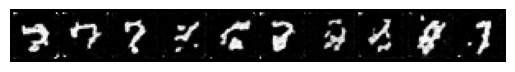

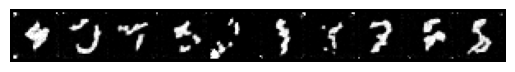

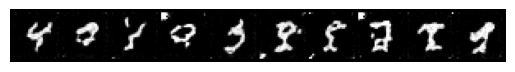

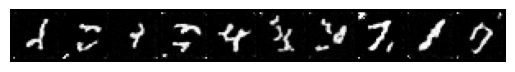

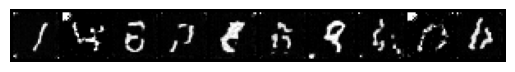

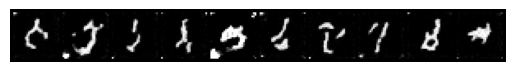

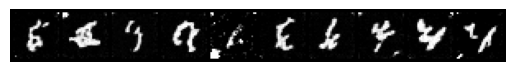

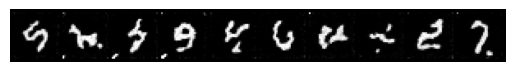

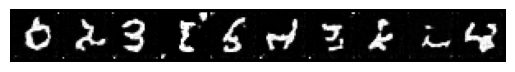

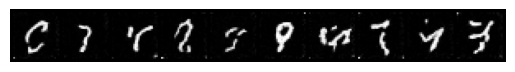

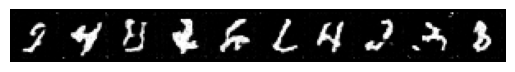

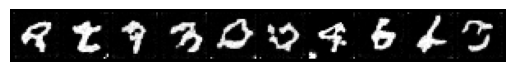

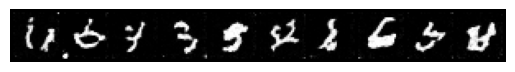

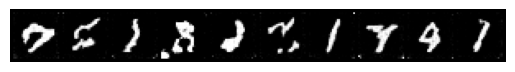

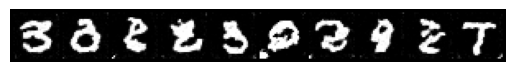

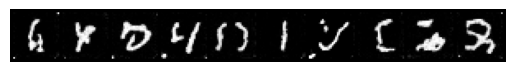

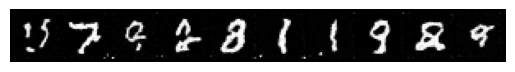

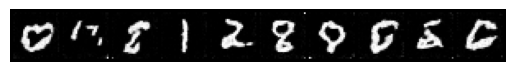

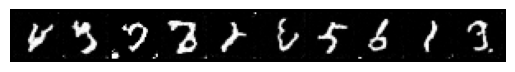

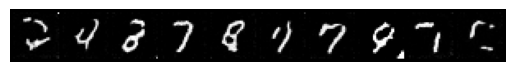

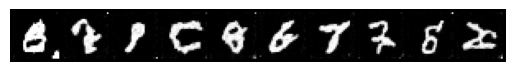

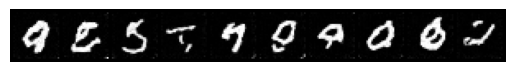

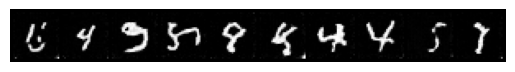

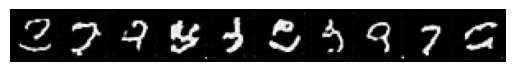

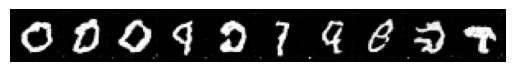

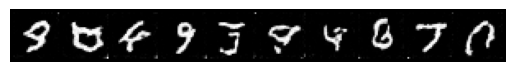

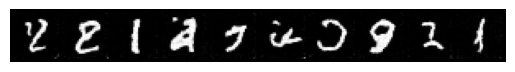

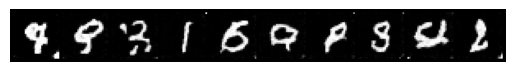

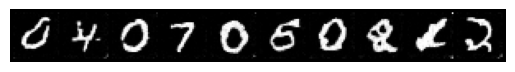

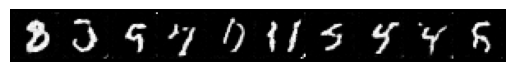

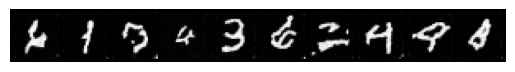

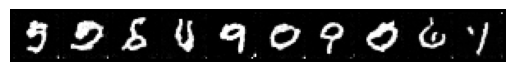

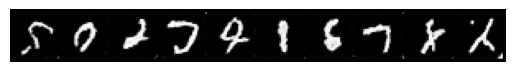

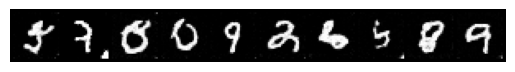

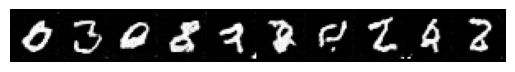

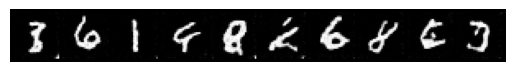

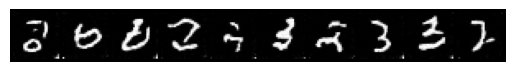

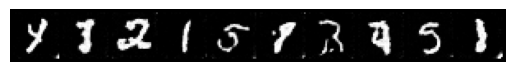

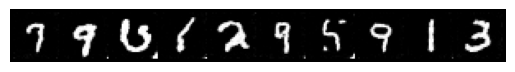

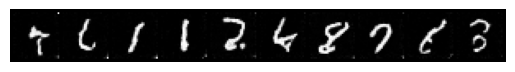

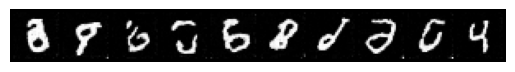

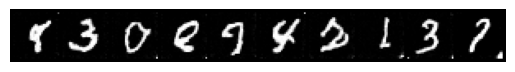

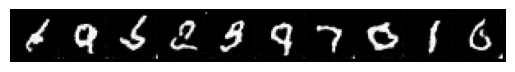

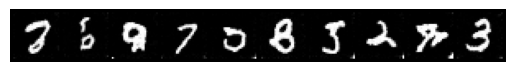

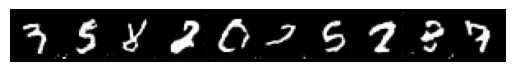

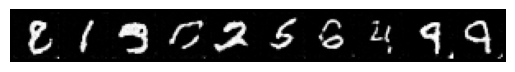

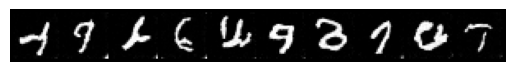

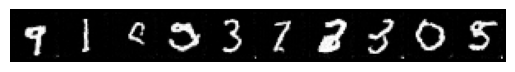

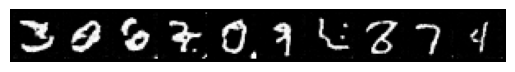

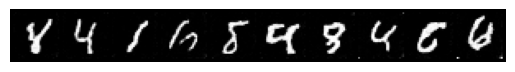

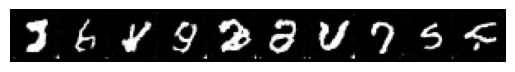

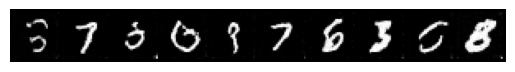

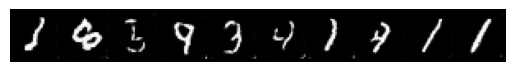

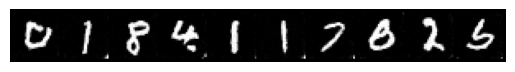

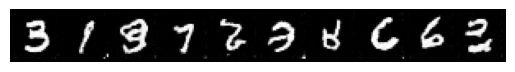

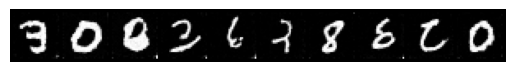

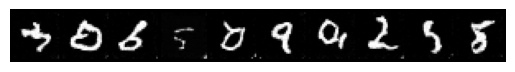

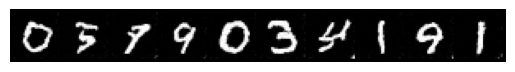

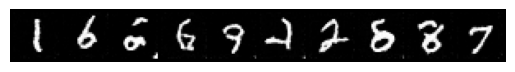

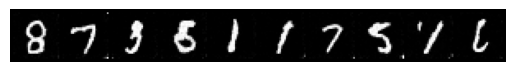

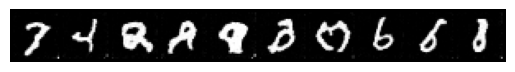

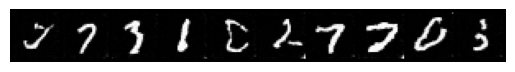

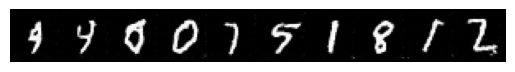

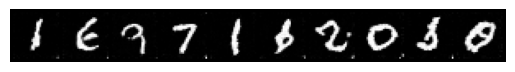

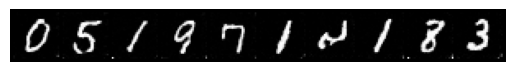

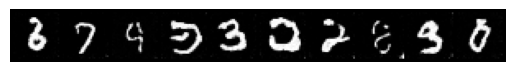

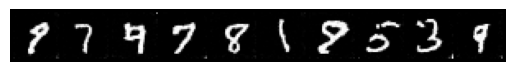

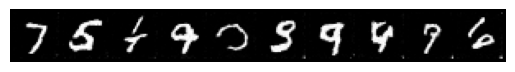

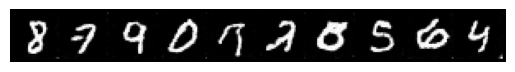

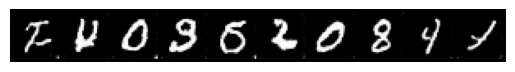

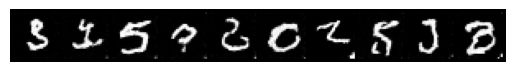

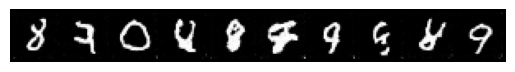

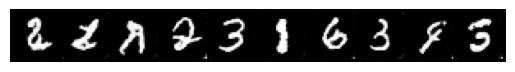

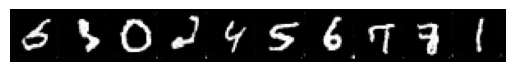

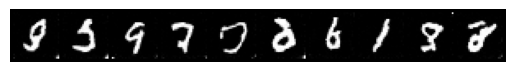

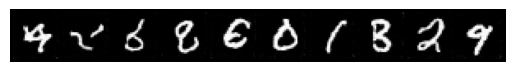

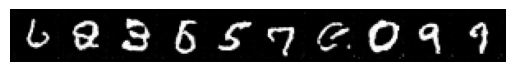

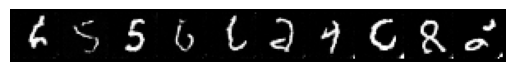

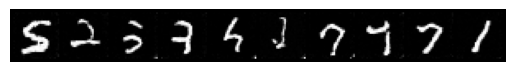

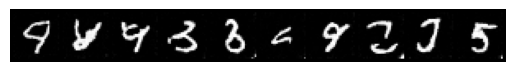

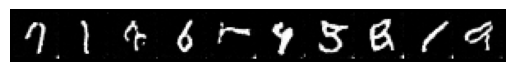

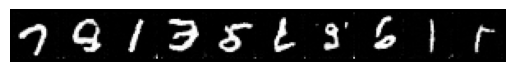

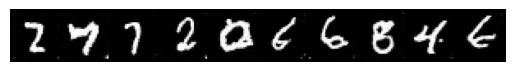

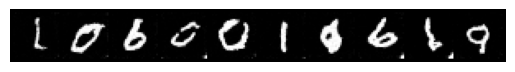

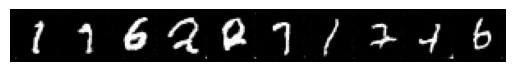

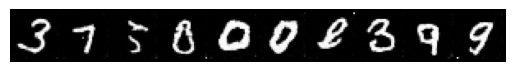

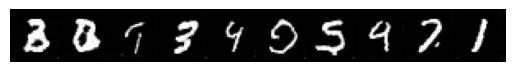

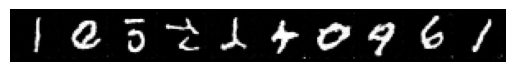

In [4]:
class DDPM(nn.Module):

    def __init__(self, network, T=100, beta_1=1e-4, beta_T=2e-2):
        """
        Initialize Denoising Diffusion Probabilistic Model

        Parameters
        ----------
        network: nn.Module
            The inner neural network used by the diffusion process. Typically a Unet.
        beta_1: float
            beta_t value at t=1 
        beta_T: [float]
            beta_t value at t=T (last step)
        T: int
            The number of diffusion steps.
        """
        
        super(DDPM, self).__init__()

        # Normalize time input before evaluating neural network
        # Reshape input into image format and normalize time value before sending it to network model
        self._network = network
        self.network = lambda x, t: (self._network(x.reshape(-1, 1, 28, 28), 
                                                   (t.squeeze()/T))
                                    ).reshape(-1, 28*28)

        # Total number of time steps
        self.T = T

        # Registering as buffers to ensure they get transferred to the GPU automatically
        self.register_buffer("beta", torch.linspace(beta_1, beta_T, T+1))
        self.register_buffer("alpha", 1-self.beta)
        self.register_buffer("alpha_bar", self.alpha.cumprod(dim=0))
        

    def forward_diffusion(self, x0, t, epsilon):
        '''
        q(x_t | x_0)
        Forward diffusion from an input datapoint x0 to an xt at timestep t, provided a N(0,1) noise sample epsilon. 
        Note that we can do this operation in a single step

        Parameters
        ----------
        x0: torch.tensor
            x value at t=0 (an input image)
        t: int
            step index 
        epsilon:
            noise sample

        Returns
        -------
        torch.tensor
            image at timestep t
        ''' 

        mean = torch.sqrt(self.alpha_bar[t])*x0
        std = torch.sqrt(1 - self.alpha_bar[t])
        
        return mean + std*epsilon

    def reverse_diffusion(self, xt, t, epsilon):
        """
        p(x_{t-1} | x_t)
        Single step in the reverse direction, from x_t (at timestep t) to x_{t-1}, provided a N(0,1) noise sample epsilon.

        Parameters
        ----------
        xt: torch.tensor
            x value at step t
        t: int
            step index
        epsilon:
            noise sample

        Returns
        -------
        torch.tensor
            image at timestep t-1
        """

        mean =  1./torch.sqrt(self.alpha[t]) * (xt - (self.beta[t])/torch.sqrt(1-self.alpha_bar[t])*self.network(xt, t)) 
        std = torch.where(t>0, torch.sqrt(((1-self.alpha_bar[t-1]) / (1-self.alpha_bar[t]))*self.beta[t]), 0)
        
        return mean + std*epsilon

    
    @torch.no_grad()
    def sample(self, shape):
        """
        Sample from diffusion model (Algorithm 2 in Ho et al, 2020)

        Parameters
        ----------
        shape: tuple
            Specify shape of sampled output. For MNIST: (nsamples, 28*28)

        Returns
        -------
        torch.tensor
            sampled image            
        """
        
        # Sample xT: Gaussian noise
        xT = torch.randn(shape).to(self.beta.device)

        xt = xT
        for t in range(self.T, 0, -1):
            noise = torch.randn_like(xT) if t > 1 else 0
            t = torch.tensor(t).expand(xt.shape[0], 1).to(self.beta.device)            
            xt = self.reverse_diffusion(xt, t, noise)

        return xt

    
    def elbo_simple(self, x0):
        """
        ELBO training objective (Algorithm 1 in Ho et al, 2020)

        Parameters
        ----------
        x0: torch.tensor
            Input image

        Returns
        -------
        float
            ELBO value            
        """

        # Sample time step t
        t = torch.randint(1, self.T, (x0.shape[0],1)).to(x0.device)
        
        # Sample noise
        epsilon = torch.randn_like(x0)

        # TODO: Forward diffusion to produce image at step t
        xt = self.forward_diffusion(x0, t, epsilon)
        
        return -nn.MSELoss(reduction='mean')(epsilon, self.network(xt, t))

    
    def loss(self, x0):
        """
        Loss function. Just the negative of the ELBO.
        """
        return -self.elbo_simple(x0).mean()


def train(model, optimizer, scheduler, dataloader, epochs, device, ema=True, per_epoch_callback=None):
    """
    Training loop
    
    Parameters
    ----------
    model: nn.Module
        Pytorch model
    optimizer: optim.Optimizer
        Pytorch optimizer to be used for training
    scheduler: optim.LRScheduler
        Pytorch learning rate scheduler
    dataloader: utils.DataLoader
        Pytorch dataloader
    epochs: int
        Number of epochs to train
    device: torch.device
        Pytorch device specification
    ema: Boolean
        Whether to activate Exponential Model Averaging
    per_epoch_callback: function
        Called at the end of every epoch
    """

    # Setup progress bar
    total_steps = len(dataloader)*epochs
    progress_bar = tqdm(range(total_steps), desc="Training")

    if ema:
        ema_global_step_counter = 0
        ema_steps = 10
        ema_adjust = dataloader.batch_size * ema_steps / epochs
        ema_decay = 1.0 - 0.995
        ema_alpha = min(1.0, (1.0 - ema_decay) * ema_adjust)
        ema_model = ExponentialMovingAverage(model, device=device, decay=1.0 - ema_alpha)                
    
    for epoch in range(epochs):

        # Switch to train mode
        model.train()

        global_step_counter = 0
        for i, (x, _) in enumerate(dataloader):
            x = x.to(device)
            optimizer.zero_grad()
            loss = model.loss(x)
            loss.backward()
            optimizer.step()
            scheduler.step()

            # Update progress bar
            progress_bar.set_postfix(loss=f"⠀{loss.item():12.4f}", epoch=f"{epoch+1}/{epochs}", lr=f"{scheduler.get_last_lr()[0]:.2E}")
            progress_bar.update()

            if ema:
                ema_global_step_counter += 1
                if ema_global_step_counter%ema_steps==0:
                    ema_model.update_parameters(model)                
        
        if per_epoch_callback:
            per_epoch_callback(ema_model.module if ema else model)


# Parameters
T = 1000
learning_rate = 1e-3
epochs = 100
batch_size = 256


# Rather than treating MNIST images as discrete objects, as done in Ho et al 2020, 
# we here treat them as continuous input data, by dequantizing the pixel values (adding noise to the input data)
# Also note that we map the 0..255 pixel values to [-1, 1], and that we process the 28x28 pixel values as a flattened 784 tensor.
transform = transforms.Compose([
    transforms.ToTensor(), 
    transforms.Lambda(lambda x: x + torch.rand(x.shape)/255),    # Dequantize pixel values
    transforms.Lambda(lambda x: (x-0.5)*2.0),                    # Map from [0,1] -> [-1, -1]
    transforms.Lambda(lambda x: x.flatten())
])

# Download and transform train dataset
dataloader_train = torch.utils.data.DataLoader(datasets.MNIST('./mnist_data', download=True, train=True, transform=transform),
                                                batch_size=batch_size,
                                                shuffle=True)

# Select device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Construct Unet
# The original ScoreNet expects a function with std for all the
# different noise levels, such that the output can be rescaled.
# Since we are predicting the noise (rather than the score), we
# ignore this rescaling and just set std=1 for all t.
mnist_unet = ScoreNet((lambda t: torch.ones(1).to(device)))

# Construct model
base_model = DDPM(mnist_unet, T=T).to(device)

# Construct optimizer
optimizer = torch.optim.Adam(base_model.parameters(), lr=learning_rate)

# Setup simple scheduler
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, 0.9999)


def reporter(model):
    """Callback function used for plotting images during training"""
    
    # Switch to eval mode
    model.eval()

    with torch.no_grad():
        nsamples = 10
        samples = model.sample((nsamples,28*28)).cpu()
        
        # Map pixel values back from [-1,1] to [0,1]
        samples = (samples+1)/2 
        samples = samples.clamp(0.0, 1.0)

        # Plot in grid
        grid = utils.make_grid(samples.reshape(-1, 1, 28, 28), nrow=nsamples)
        plt.gca().set_axis_off()
        plt.imshow(transforms.functional.to_pil_image(grid), cmap="gray")
        plt.show()    

# Call training loop
train(base_model, optimizer, scheduler, dataloader_train, 
      epochs=epochs, device=device, ema=True, per_epoch_callback=reporter)


Training:   0%|          | 0/23500 [00:00<?, ?it/s]

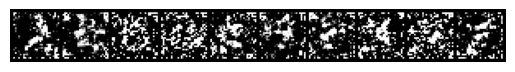

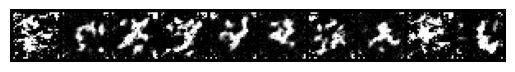

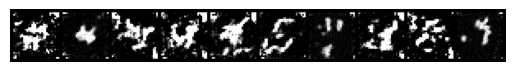

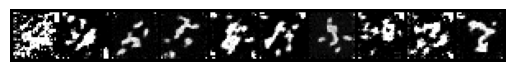

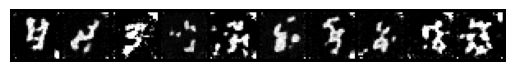

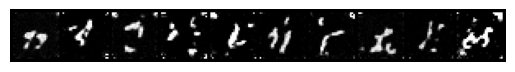

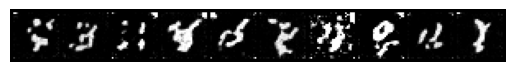

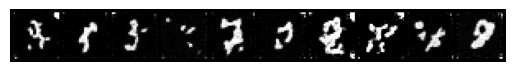

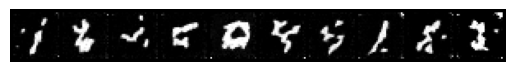

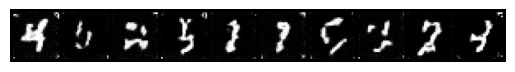

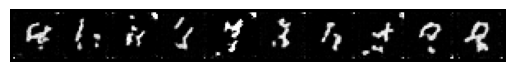

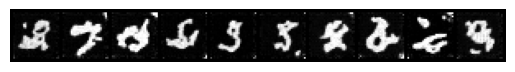

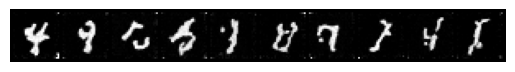

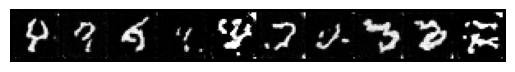

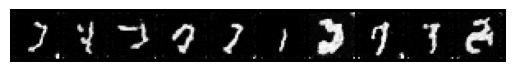

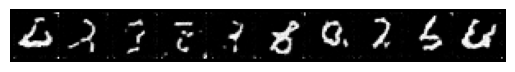

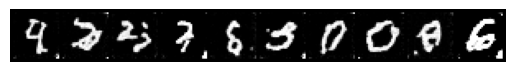

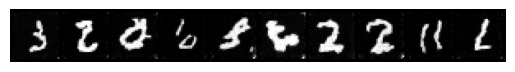

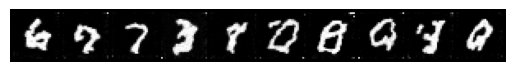

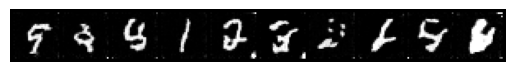

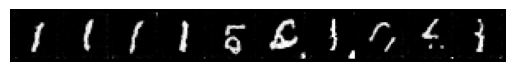

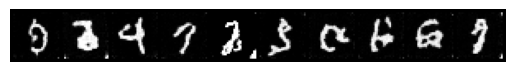

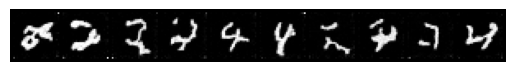

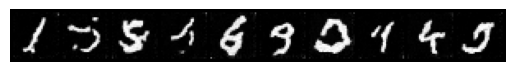

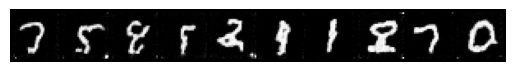

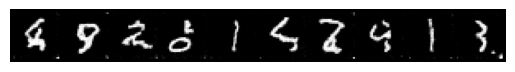

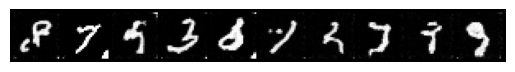

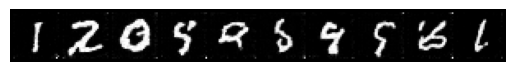

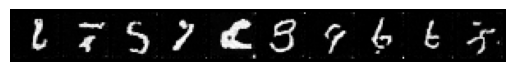

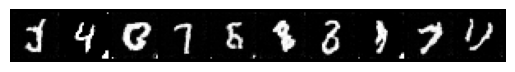

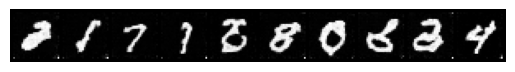

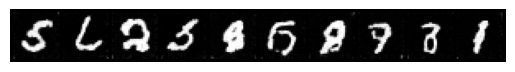

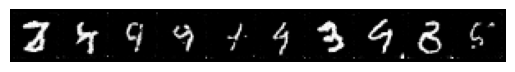

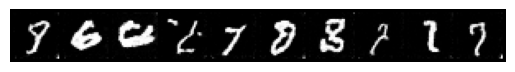

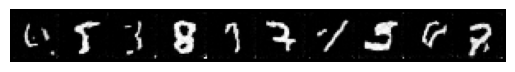

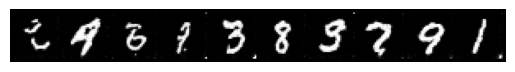

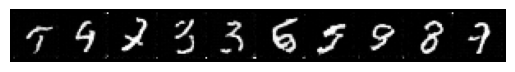

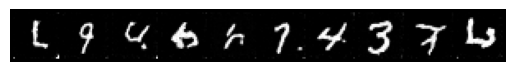

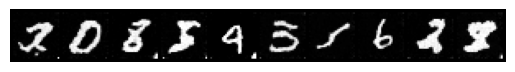

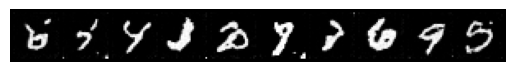

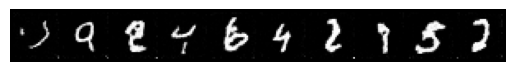

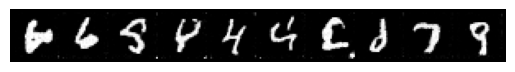

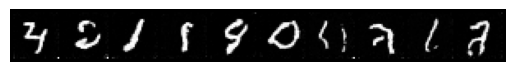

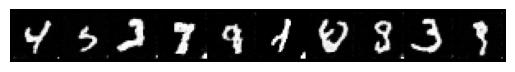

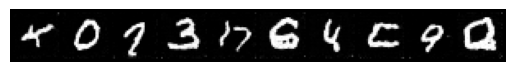

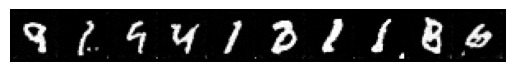

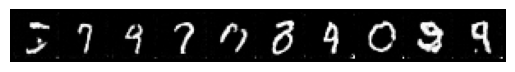

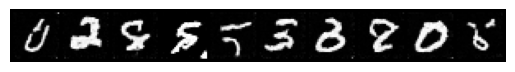

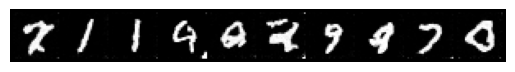

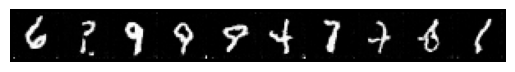

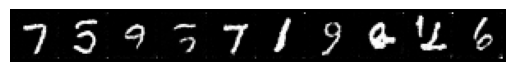

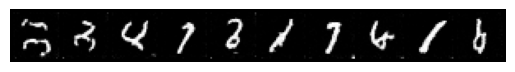

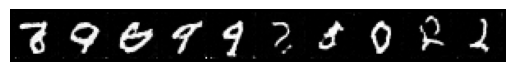

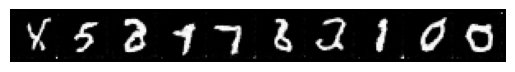

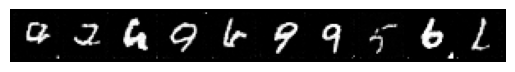

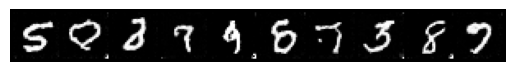

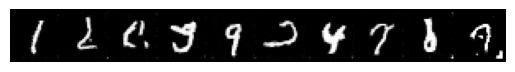

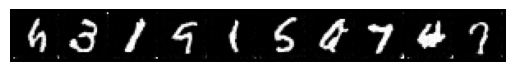

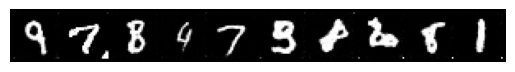

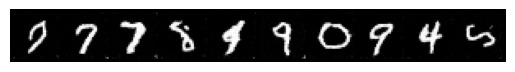

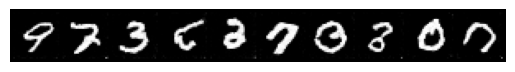

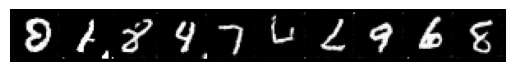

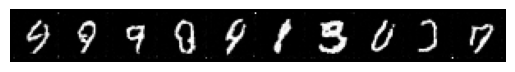

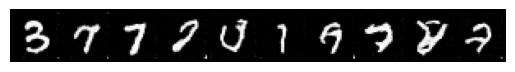

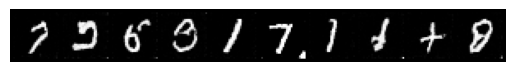

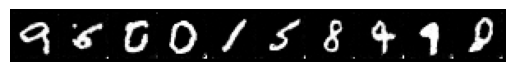

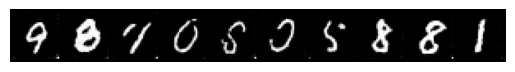

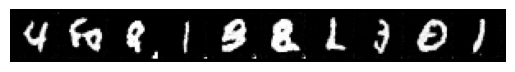

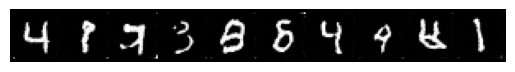

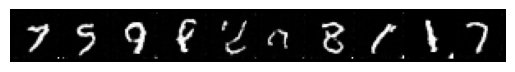

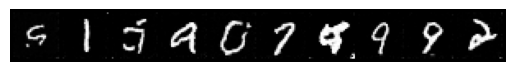

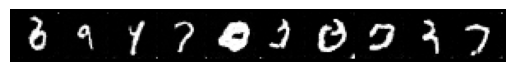

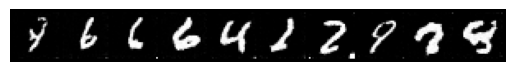

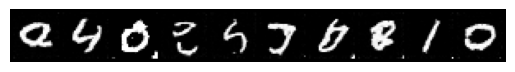

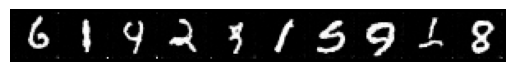

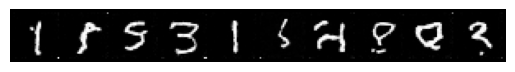

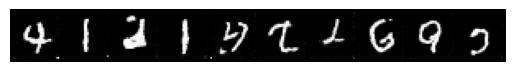

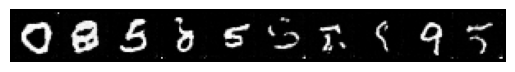

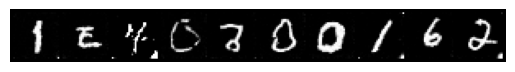

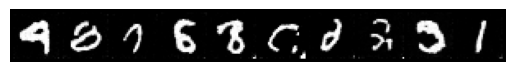

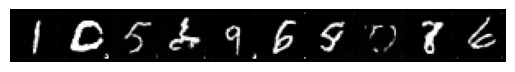

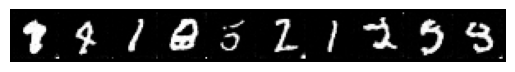

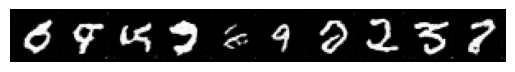

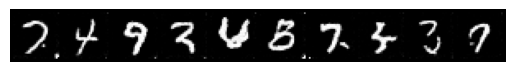

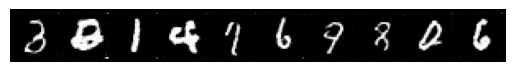

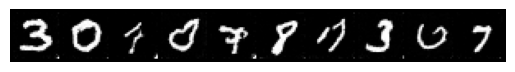

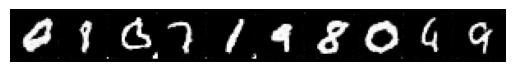

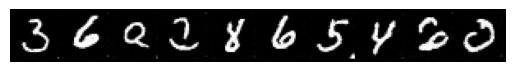

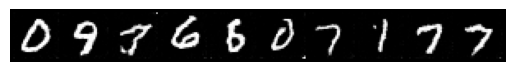

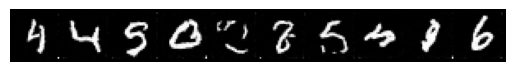

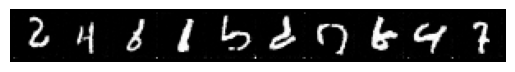

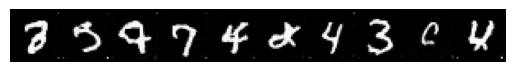

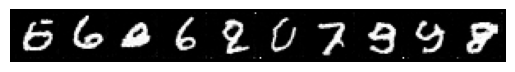

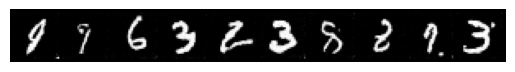

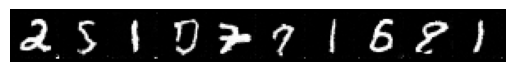

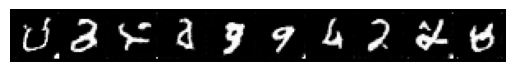

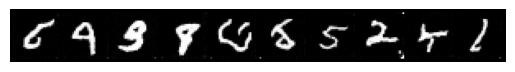

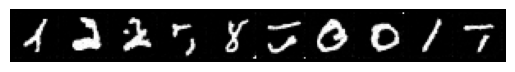

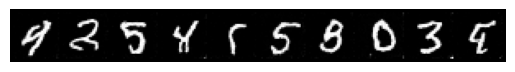

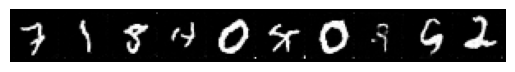

In [48]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Classifier(nn.Module):
    """Simple classifier for MNIST digits that works with noisy images"""
    def __init__(self):
        super().__init__()
        # Use same channel progression as the UNet for consistency
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.pool = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(128 * 3 * 3, 256)
        self.fc2 = nn.Linear(256, 10)
        
    def forward(self, x, t=None):
        # t is ignored but kept for API consistency
        x = x.reshape(-1, 1, 28, 28)  # Ensure correct shape
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = F.relu(self.conv3(x))
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

class ImprovedGuidedDDPM(DDPM):
    def __init__(self, network, classifier, T=1000, beta_1=1e-4, beta_T=2e-2, guidance_scale=7.5):
        super().__init__(network, T, beta_1, beta_T)
        self.classifier = classifier
        self.guidance_scale = guidance_scale
        
    def get_classifier_gradient(self, x, t, y):
        """Calculate gradients from classifier for guidance"""
        with torch.enable_grad():
            x_in = x.detach().requires_grad_(True)
            logits = self.classifier(x_in, t)
            log_probs = F.log_softmax(logits, dim=-1)
            selected = log_probs[range(len(logits)), y]
            return torch.autograd.grad(selected.sum(), x_in)[0]
    
    def reverse_diffusion(self, xt, t, epsilon, y=None):
        base_pred = self.network(xt, t)
        
        if y is not None:
            with torch.no_grad():
                grad = self.get_classifier_gradient(xt, t, y)
                # Modified scaling factor
                grad_scale = self.guidance_scale * torch.sqrt(self.alpha_bar[t])
                base_pred = base_pred + grad_scale * grad
        
        # Modified mean computation
        mean = (1 / torch.sqrt(self.alpha[t])) * (
            xt - ((1 - self.alpha[t]) / torch.sqrt(1 - self.alpha_bar[t])) * base_pred
        )
            
        std = torch.where(
                t>0, 
                torch.sqrt(((1-self.alpha_bar[t-1])/(1-self.alpha_bar[t]))*self.beta[t]), 
                torch.zeros_like(t)
            )
        
        return mean + std*epsilon
    
    @torch.no_grad()
    def sample(self, shape, labels=None):
        """Sample from model with optional classifier guidance"""
        xT = torch.randn(shape).to(self.beta.device)
        xt = xT
        
        for t in range(self.T, 0, -1):
            noise = torch.randn_like(xT) if t > 1 else torch.zeros_like(xT)
            t_expanded = torch.full((xt.shape[0], 1), t, device=self.beta.device)
            xt = self.reverse_diffusion(xt, t_expanded, noise, labels)
            
        return xt

def train_classifier(classifier, dataloader, device, num_epochs=5):
    """Train the classifier on noisy images"""
    optimizer = torch.optim.Adam(classifier.parameters())
    criterion = nn.CrossEntropyLoss()
    
    for epoch in range(num_epochs):
        classifier.train()
        for batch_idx, (data, target) in enumerate(dataloader):
            data, target = data.to(device), target.to(device)
            # Add noise to input images
            t = torch.randint(1, 1000, (data.shape[0],1)).to(device)
            noise = torch.randn_like(data)
            noisy_data = torch.sqrt(1 - t/1000) * data + torch.sqrt(t/1000) * noise
            
            optimizer.zero_grad()
            output = classifier(noisy_data, t)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            
    return classifier

# Setup and training
classifier = Classifier().to(device)
classifier = train_classifier(classifier, dataloader_train, device)

mnist_unet = ScoreNet((lambda t: torch.ones(1).to(device)))
guided_model = ImprovedGuidedDDPM(
    mnist_unet, 
    classifier,
    T=T, 
    guidance_scale=7.0
).to(device)

# Training setup
optimizer = torch.optim.Adam(guided_model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, 0.9999)

# Call training loop
train(guided_model, optimizer, scheduler, dataloader_train, 
      epochs=epochs, device=device, ema=True, per_epoch_callback=reporter)

In [49]:
class ConditionalScoreNet(ScoreNet):
  """A time-dependent score-based model with class conditioning."""

  def __init__(self, marginal_prob_std, channels=[32, 64, 128, 256], embed_dim=256, num_classes=10):
    """Initialize a time-dependent score-based network with conditioning.
    
    Args:
      marginal_prob_std: A function that takes time t and gives the standard
        deviation of the perturbation kernel p_{0t}(x(t) | x(0)).
      channels: The number of channels for feature maps of each resolution.
      embed_dim: The dimensionality of Gaussian random feature embeddings.
      num_classes: Number of classes for conditioning.
    """
    super().__init__(marginal_prob_std, channels, embed_dim)
    
    # Only add what's new for conditioning
    self.class_embed = nn.Embedding(num_classes + 1, embed_dim)  # +1 for unconditional case
    self.combine_embeds = nn.Linear(embed_dim * 2, embed_dim)
  
  def forward(self, x, t, y=None): 
    # Get time embedding from parent class
    embed = self.act(self.embed(t))
    
    # Get class embedding (use num_classes for unconditional case)
    if y is None:
        y = torch.full((x.shape[0],), self.class_embed.num_embeddings - 1, 
                      device=x.device, dtype=torch.long)
    class_embed = self.class_embed(y)
    
    # Combine time and class embeddings
    embed = self.combine_embeds(torch.cat([embed, class_embed], dim=-1))
    embed = self.act(embed)
    
    # Rest of the forward pass remains the same as parent
    h1 = self.conv1(x)    
    h1 += self.dense1(embed)
    h1 = self.gnorm1(h1)
    h1 = self.act(h1)
    h2 = self.conv2(h1)
    h2 += self.dense2(embed)
    h2 = self.gnorm2(h2)
    h2 = self.act(h2)
    h3 = self.conv3(h2)
    h3 += self.dense3(embed)
    h3 = self.gnorm3(h3)
    h3 = self.act(h3)
    h4 = self.conv4(h3)
    h4 += self.dense4(embed)
    h4 = self.gnorm4(h4)
    h4 = self.act(h4)

    h = self.tconv4(h4)
    h += self.dense5(embed)
    h = self.tgnorm4(h)
    h = self.act(h)
    h = self.tconv3(torch.cat([h, h3], dim=1))
    h += self.dense6(embed)
    h = self.tgnorm3(h)
    h = self.act(h)
    h = self.tconv2(torch.cat([h, h2], dim=1))
    h += self.dense7(embed)
    h = self.tgnorm2(h)
    h = self.act(h)
    h = self.tconv1(torch.cat([h, h1], dim=1))

    h = h / self.marginal_prob_std(t)[:, None, None, None]
    return h

Training:   0%|          | 0/23500 [00:00<?, ?it/s]

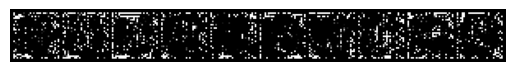

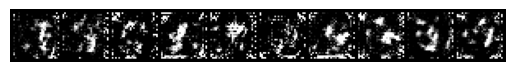

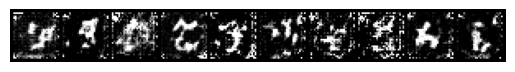

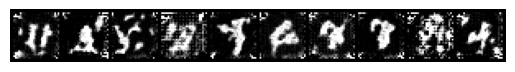

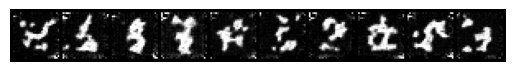

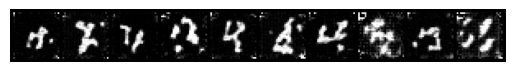

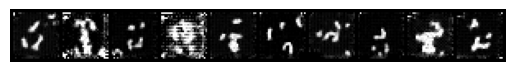

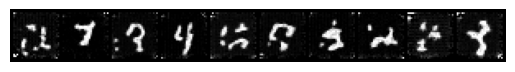

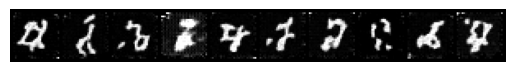

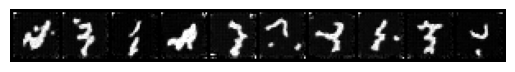

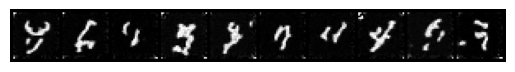

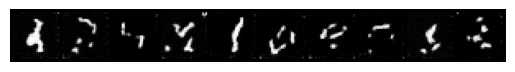

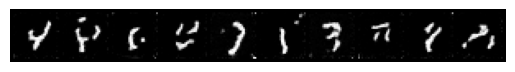

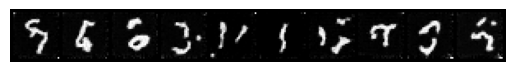

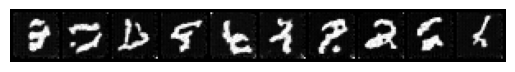

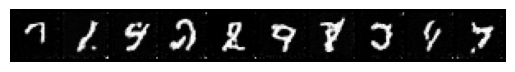

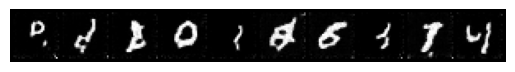

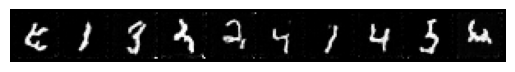

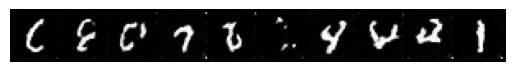

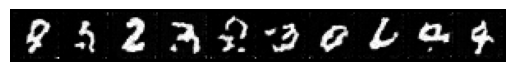

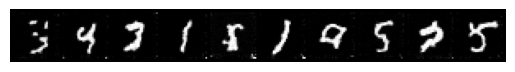

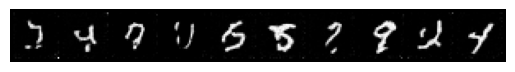

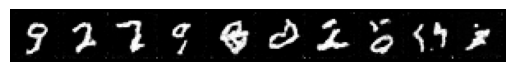

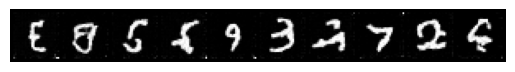

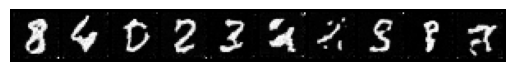

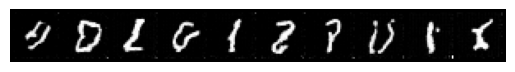

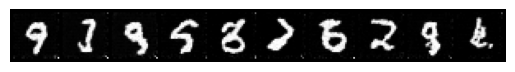

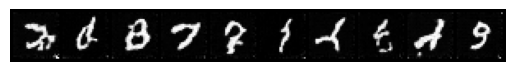

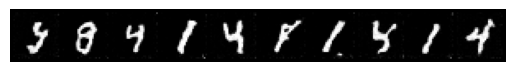

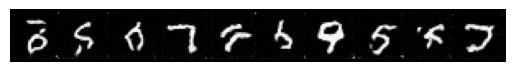

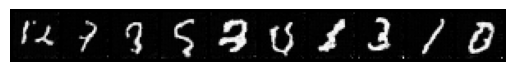

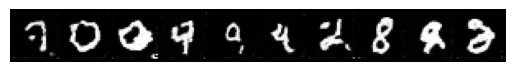

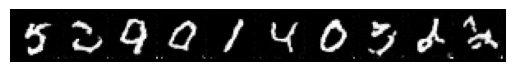

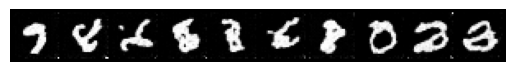

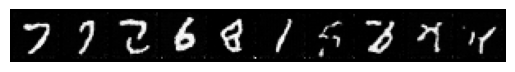

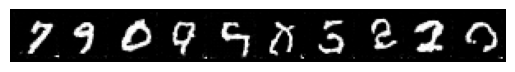

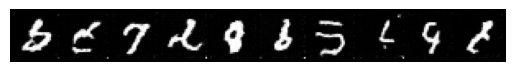

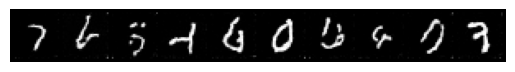

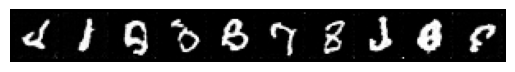

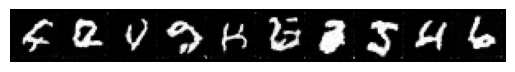

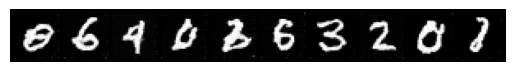

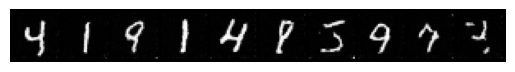

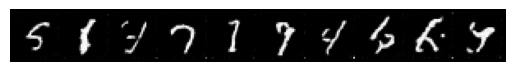

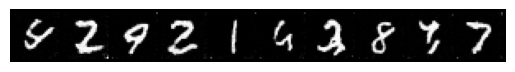

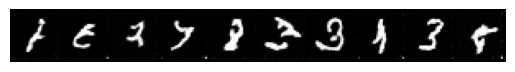

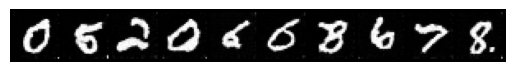

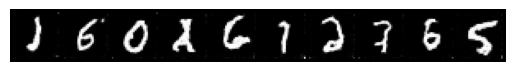

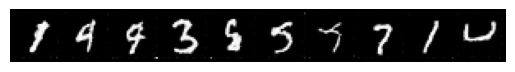

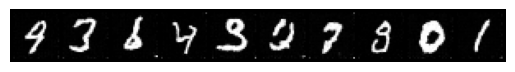

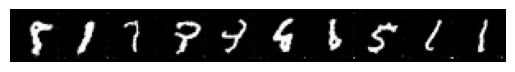

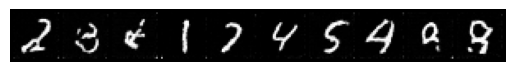

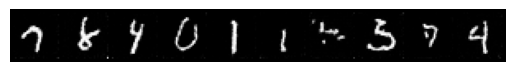

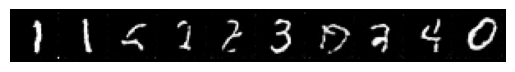

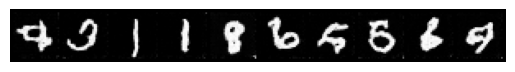

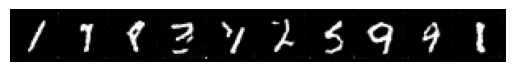

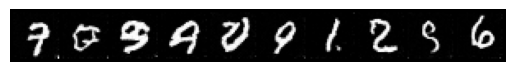

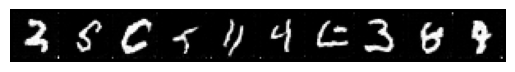

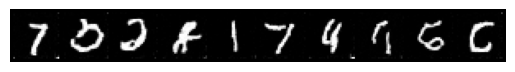

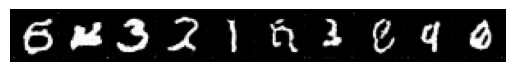

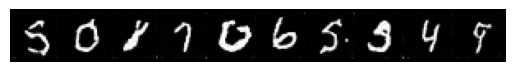

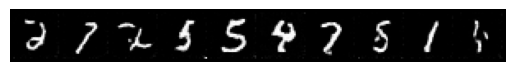

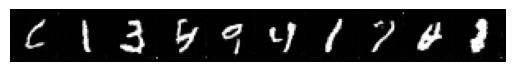

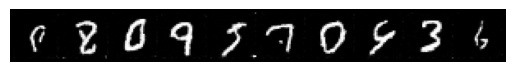

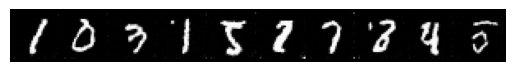

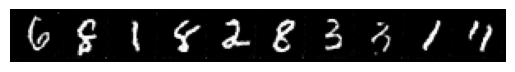

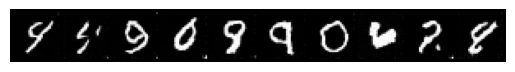

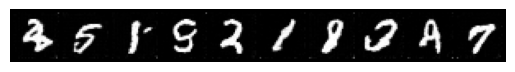

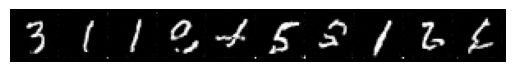

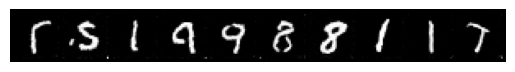

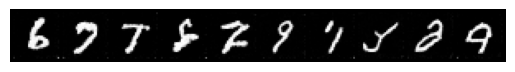

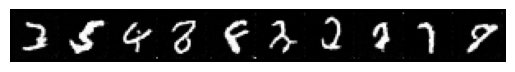

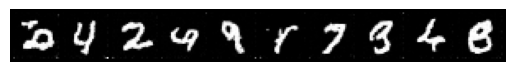

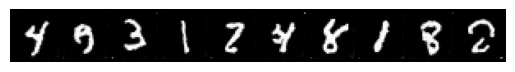

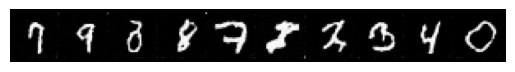

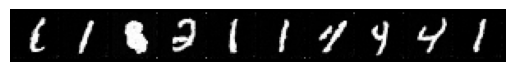

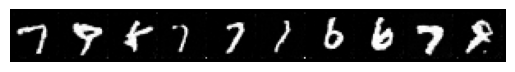

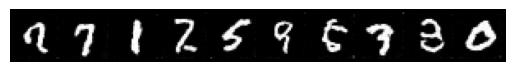

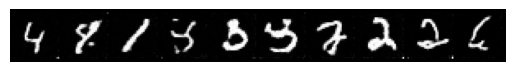

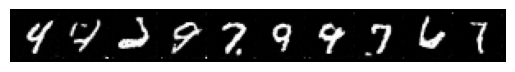

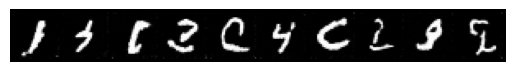

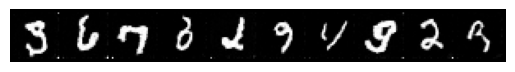

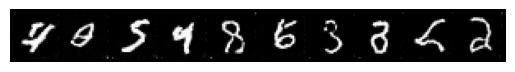

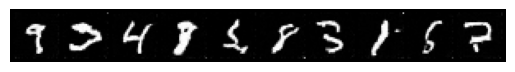

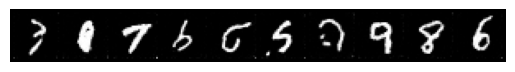

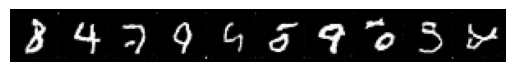

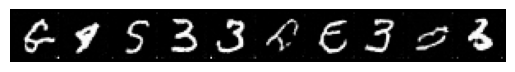

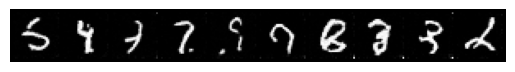

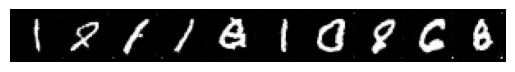

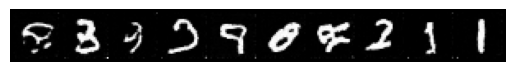

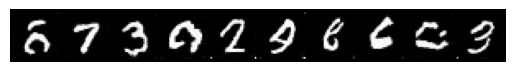

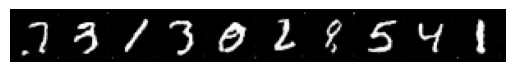

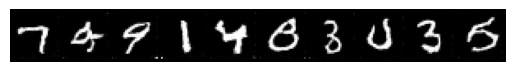

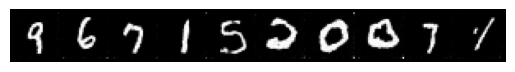

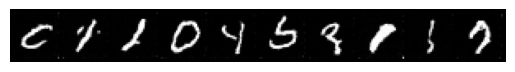

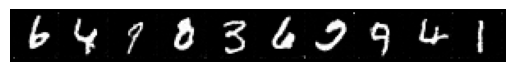

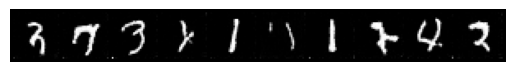

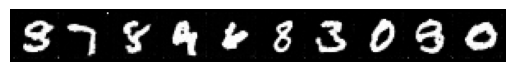

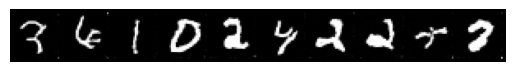

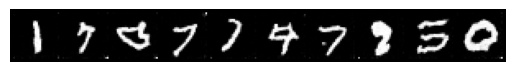

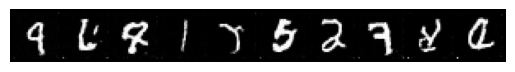

In [50]:
class CFG_DDPM(DDPM):
    def __init__(self, network, T=1000, beta_1=1e-4, beta_T=2e-2, guidance_scale=7.5, p_uncond=0.1):
        """Initialize CFG-DDPM with joint training capability.
        
        Args:
            network: The score network (UNet)
            T: Number of diffusion steps
            beta_1: Initial beta value
            beta_T: Final beta value
            guidance_scale: Guidance strength for sampling (w in the paper)
            p_uncond: Probability of training unconditionally (puncond in the paper)
        """
        super().__init__(network, T, beta_1, beta_T)
        self.guidance_scale = guidance_scale
        self.p_uncond = p_uncond
        
    def forward(self, x, t, y=None):
        """Forward pass with random conditioning dropout during training."""
        # During training, randomly drop class conditioning
        if self.training and torch.rand(1) < self.p_uncond:
            y = None
            
        # Get prediction (handle both conditional and unconditional cases)
        if y is not None:
            # For conditional prediction, pass labels
            pred = self.network(x, t)  # Your ScoreNet needs to be modified to handle y
        else:
            # For unconditional prediction, pass null token or no conditioning
            pred = self.network(x, t)
            
        return pred
    
    def reverse_diffusion(self, xt, t, epsilon, y=None):
        """Classifier-free guided reverse diffusion process.
        
        Following equation (6) in the paper:
        ˜ϵθ(zλ,c) = (1 + w)ϵθ(zλ,c) - wϵθ(zλ)
        """
        # Get conditional score
        pred_conditional = self.network(xt, t)  # Should pass y once ScoreNet supports it
        
        # Get unconditional score 
        pred_unconditional = self.network(xt, t)  # No conditioning
        
        # Combine scores according to equation (6) in the paper
        guided_score = (1 + self.guidance_scale) * pred_conditional - self.guidance_scale * pred_unconditional
        
        # Apply guided score in the reverse diffusion formula
        mean = 1./torch.sqrt(self.alpha[t]) * (
            xt - (self.beta[t])/torch.sqrt(1-self.alpha_bar[t]) * guided_score
        )
        
        std = torch.where(
            t>0,
            torch.sqrt(((1-self.alpha_bar[t-1])/(1-self.alpha_bar[t]))*self.beta[t]),
            torch.zeros_like(t)
        )
        
        return mean + std*epsilon

    def loss(self, x0, y=None):
        """Modified loss function to handle joint training."""
        # Regular DDPM loss from parent class
        base_loss = super().loss(x0)
        
        # During training, we're already handling the conditional/unconditional
        # split in the forward pass, so we can just return the base loss
        return base_loss
        
    @torch.no_grad()
    def sample(self, shape, labels=None):
        """Sample using classifier-free guidance."""
        # Start from random noise
        xT = torch.randn(shape).to(self.beta.device)
        xt = xT
        
        # Reverse diffusion with guidance
        for t in range(self.T, 0, -1):
            noise = torch.randn_like(xT) if t > 1 else torch.zeros_like(xT)
            t_expanded = torch.full((xt.shape[0], 1), t, device=self.beta.device)
            xt = self.reverse_diffusion(xt, t_expanded, noise, labels)
            
        return xt


# Create the conditional score network
cond_score_net = ConditionalScoreNet(
    marginal_prob_std=(lambda t: torch.ones(1).to(device)),
    num_classes=10  # For MNIST
).to(device)

# Create guided diffusion model 
mnist_unet = ScoreNet((lambda t: torch.ones(1).to(device)))
# Create the CFG model
cfg_model = CFG_DDPM(
    network=cond_score_net,
    T=T,
    guidance_scale=7.0,
    p_uncond=0.1  # As recommended in the paper
).to(device)

# Training setup remains the same
optimizer = torch.optim.Adam(cfg_model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, 0.9999)

# Call training loop
train(cfg_model, optimizer, scheduler, dataloader_train, 
      epochs=epochs, device=device, ema=True, per_epoch_callback=reporter)

In [51]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models import inception_v3
from scipy import linalg
import numpy as np
from tqdm.auto import tqdm
from typing import Dict, List, Optional, Tuple

class InceptionStatistics:
    """Compute inception statistics for FID and IS scores"""
    def __init__(self, device):
        self.device = device
        self.inception = inception_v3(pretrained=True, transform_input=False).to(device)
        self.inception.eval()
        
        # Create a hook to capture features
        self.features = None
        def hook(module, input, output):
            self.features = output.detach()
        
        # Register the hook on the avgpool layer
        self.inception.avgpool.register_forward_hook(hook)
    
    def get_inception_features(self, images: torch.Tensor, batch_size: int = 50) -> Tuple[np.ndarray, np.ndarray]:
        """Extract both features and logits in a single pass"""
        n_samples = images.shape[0]
        features_list = []
        logits_list = []
        
        for i in range(0, n_samples, batch_size):
            batch = images[i:i+batch_size]
            if batch.dim() == 2:
                batch = batch.reshape(-1, 1, 28, 28)
            if batch.shape[1] == 1:
                batch = batch.repeat(1, 3, 1, 1)
                
            # Resize to inception input size
            batch = F.interpolate(batch, size=(299, 299), mode='bilinear', align_corners=False)
            
            with torch.no_grad():
                logits = self.inception(batch)
                features = self.features.squeeze()
                
            features_list.append(features.cpu().numpy())
            logits_list.append(logits.cpu().numpy())
            
        return np.concatenate(features_list), np.concatenate(logits_list)

    def compute_statistics(self, features: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
        """Compute mean and covariance for FID"""
        mu = np.mean(features, axis=0)
        sigma = np.cov(features, rowvar=False)
        return mu, sigma
    
    def compute_fid(self, real_features: np.ndarray, fake_features: np.ndarray) -> float:
        """Compute Fréchet Inception Distance"""
        mu1, sigma1 = self.compute_statistics(real_features)
        mu2, sigma2 = self.compute_statistics(fake_features)
        
        diff = mu1 - mu2
        covmean, _ = linalg.sqrtm(sigma1.dot(sigma2), disp=False)
        if np.iscomplexobj(covmean):
            covmean = covmean.real
        fid = diff.dot(diff) + np.trace(sigma1 + sigma2 - 2*covmean)
        return float(fid)
    
    def compute_inception_score(self, logits: np.ndarray, splits: int = 10) -> Tuple[float, float]:
        """Compute Inception Score from logits"""
        probs = F.softmax(torch.from_numpy(logits), dim=1).numpy()
        
        scores = []
        split_size = probs.shape[0] // splits
        for i in range(splits):
            part = probs[i * split_size:(i + 1) * split_size]
            kl = part * (np.log(part) - np.log(np.expand_dims(np.mean(part, 0), 0)))
            kl = np.mean(np.sum(kl, 1))
            scores.append(np.exp(kl))
            
        return np.mean(scores), np.std(scores)

def evaluate_model_multiple_runs(
    model: nn.Module,
    dataloader: torch.utils.data.DataLoader,
    evaluator: InceptionStatistics,
    n_runs: int = 5,
    n_samples: int = 1000,
    batch_size: int = 50,
    device: str = 'cuda'
) -> Dict[str, Dict[str, float]]:
    """
    Evaluate diffusion model multiple times and compute statistics
    
    Args:
        model: The model to evaluate
        dataloader: DataLoader containing real images
        evaluator: InceptionStatistics instance
        n_runs: Number of evaluation runs
        n_samples: Number of samples per run
        batch_size: Batch size for generation
        device: Device to use
        
    Returns:
        Dictionary containing mean and std of metrics
    """
    # Storage for multiple runs
    fid_scores = []
    is_means = []
    is_stds = []
    
    # Get real images once (these stay constant across runs)
    real_images = []
    for images, _ in dataloader:
        if images.dim() == 2:
            images = images.reshape(-1, 1, 28, 28)
        real_images.append(images)
        if len(real_images) * images.shape[0] >= n_samples:
            break
    real_images = torch.cat(real_images, dim=0)[:n_samples]
    
    # Compute real features once
    print("Computing inception features for real images...")
    real_features, _ = evaluator.get_inception_features(real_images.to(device))
    
    # Multiple evaluation runs
    for run in tqdm(range(n_runs), desc="Evaluation runs"):
        try:
            # Generate fake images
            model.eval()
            fake_images = []
            with torch.no_grad():
                for i in range(0, n_samples, batch_size):
                    curr_batch_size = min(batch_size, n_samples - i)
                    if hasattr(model, 'sample_with_labels'):
                        labels = torch.randint(0, 10, (curr_batch_size,)).to(device)
                        samples = model.sample((curr_batch_size, 28*28), labels)
                    else:
                        samples = model.sample((curr_batch_size, 28*28))
                    
                    samples = (samples + 1) / 2  # Map from [-1,1] to [0,1]
                    samples = samples.clamp(0, 1)
                    samples = samples.reshape(-1, 1, 28, 28)
                    fake_images.append(samples.cpu())
            
            fake_images = torch.cat(fake_images, dim=0)[:n_samples]
            
            # Compute inception features for generated images
            print(f"Computing inception features for generated images (run {run+1}/{n_runs})...")
            fake_features, fake_logits = evaluator.get_inception_features(fake_images.to(device))
            
            # Compute metrics
            fid = evaluator.compute_fid(real_features, fake_features)
            is_mean, is_std = evaluator.compute_inception_score(fake_logits)
            
            # Store results
            fid_scores.append(fid)
            is_means.append(is_mean)
            is_stds.append(is_std)
            
        except Exception as e:
            print(f"Error in evaluation run {run+1}: {str(e)}")
            continue
    
    # Compute statistics across runs
    results = {
        'FID': {
            'mean': float(np.mean(fid_scores)),
            'std': float(np.std(fid_scores))
        },
        'IS': {
            'mean': float(np.mean(is_means)),
            'std': float(np.std(is_means))
        }
    }
    
    return results

def compare_models_multiple_runs(
    base_model: nn.Module,
    guided_model: nn.Module,
    cfg_model: nn.Module,
    dataloader: torch.utils.data.DataLoader,
    device: str,
    n_runs: int = 5
) -> Dict[str, Dict[str, Dict[str, float]]]:
    """Compare multiple diffusion models with multiple evaluation runs"""
    # Create a single evaluator to be used for all models
    evaluator = InceptionStatistics(device)
    results = {}
    
    print("\nEvaluating base DDPM...")
    results['base'] = evaluate_model_multiple_runs(
        base_model, dataloader, evaluator, n_runs=n_runs, device=device
    )
    
    print("\nEvaluating classifier-guided DDPM...")
    results['guided'] = evaluate_model_multiple_runs(
        guided_model, dataloader, evaluator, n_runs=n_runs, device=device
    )
    
    print("\nEvaluating classifier-free guided DDPM...")
    results['cfg'] = evaluate_model_multiple_runs(
        cfg_model, dataloader, evaluator, n_runs=n_runs, device=device
    )
    
    # Print results
    print("\nResults:")
    print("-" * 50)
    for model_name, metrics in results.items():
        print(f"\n{model_name.capitalize()} DDPM:")
        print(f"  FID: {metrics['FID']['mean']:.2f} ± {metrics['FID']['std']:.2f}")
        print(f"  IS:  {metrics['IS']['mean']:.2f} ± {metrics['IS']['std']:.2f}")
    
    return results


Running quantitative comparison...

Evaluating base DDPM...
Computing inception features for real images...


Evaluation runs:   0%|          | 0/5 [00:00<?, ?it/s]

Computing inception features for generated images (run 1/5)...
Computing inception features for generated images (run 2/5)...
Computing inception features for generated images (run 3/5)...
Computing inception features for generated images (run 4/5)...
Computing inception features for generated images (run 5/5)...

Evaluating classifier-guided DDPM...
Computing inception features for real images...


Evaluation runs:   0%|          | 0/5 [00:00<?, ?it/s]

Computing inception features for generated images (run 1/5)...
Computing inception features for generated images (run 2/5)...
Computing inception features for generated images (run 3/5)...
Computing inception features for generated images (run 4/5)...
Computing inception features for generated images (run 5/5)...

Evaluating classifier-free guided DDPM...
Computing inception features for real images...


Evaluation runs:   0%|          | 0/5 [00:00<?, ?it/s]

Computing inception features for generated images (run 1/5)...
Computing inception features for generated images (run 2/5)...
Computing inception features for generated images (run 3/5)...
Computing inception features for generated images (run 4/5)...
Computing inception features for generated images (run 5/5)...

Results:
--------------------------------------------------

Base DDPM:
  FID: 59.80 ± 0.95
  IS:  2.12 ± 0.04

Guided DDPM:
  FID: 53.16 ± 0.78
  IS:  2.06 ± 0.02

Cfg DDPM:
  FID: 56.10 ± 0.62
  IS:  2.03 ± 0.04

Generating visualizations...
Generating base model samples...
Generating guided model samples...
Generating CFG model samples...


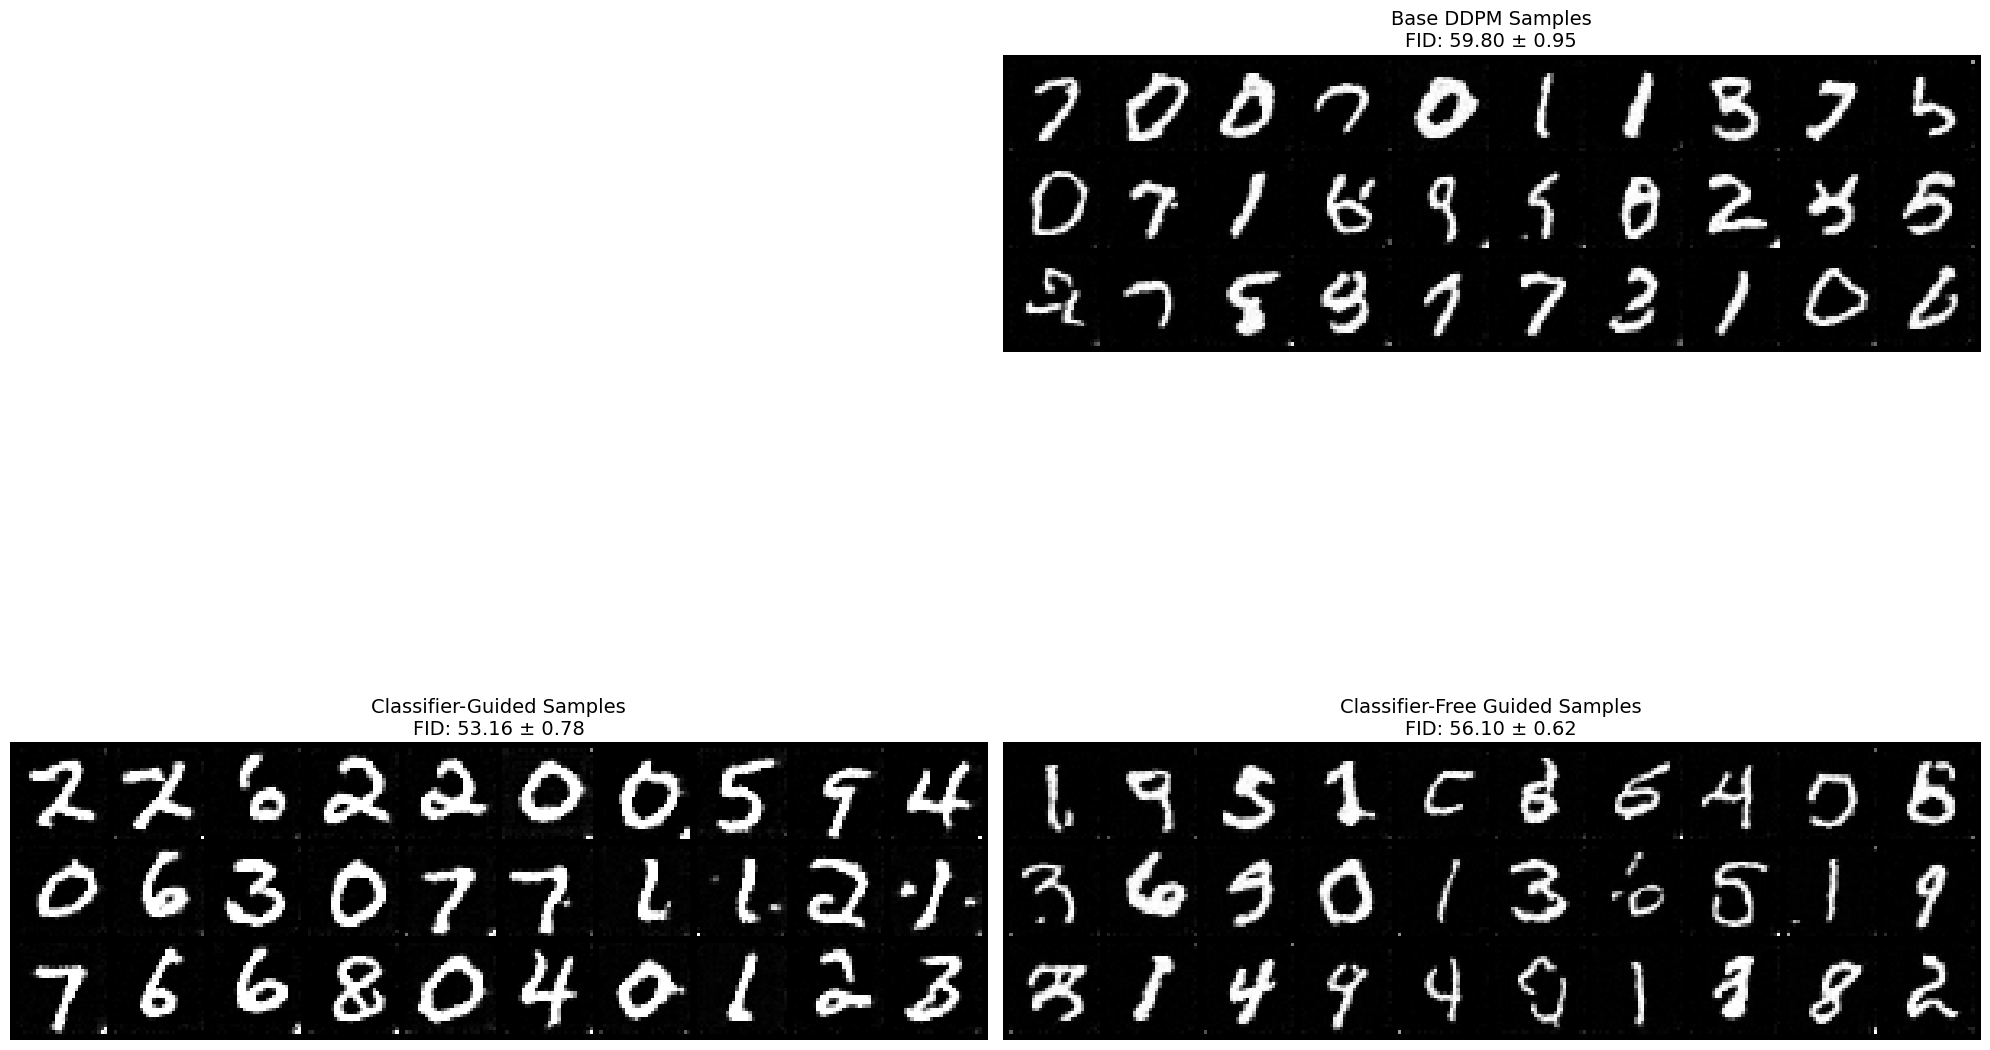

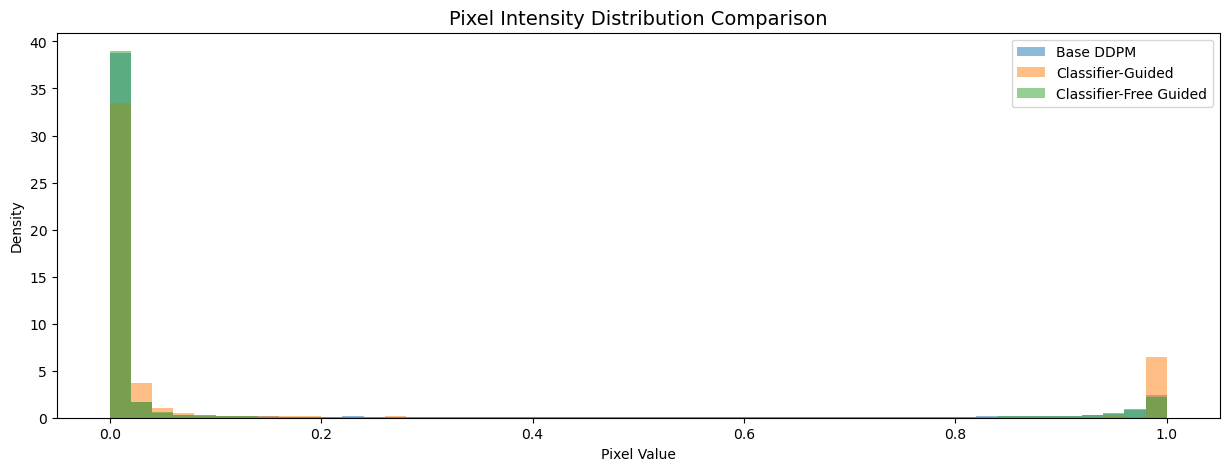

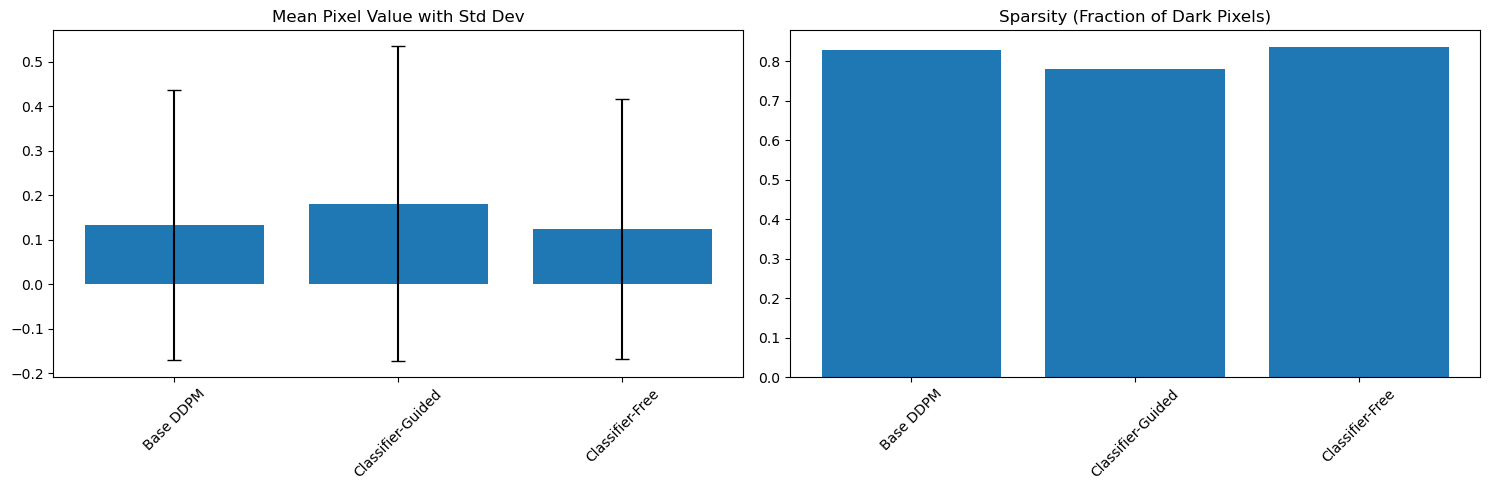

In [52]:
import torch
from torchvision import utils
import matplotlib.pyplot as plt
import numpy as np

def visualize_model_comparison(base_model, guided_model, cfg_model, dataloader, device, results, n_samples=30):
    """Generate visual comparisons between different diffusion models"""
    
    # Generate samples from each model
    def get_samples(model, with_labels=False):
        model.eval()
        with torch.no_grad():
            if with_labels:
                # Generate 3 samples for each digit
                samples = []
                for digit in range(10):
                    labels = torch.full((3,), digit, device=device)
                    sample = model.sample((3, 28*28), labels)
                    samples.append(sample)
                samples = torch.cat(samples, dim=0)
            else:
                samples = model.sample((30, 28*28))
            
            samples = (samples + 1) / 2
            samples = samples.clamp(0, 1)
            return samples.reshape(-1, 1, 28, 28)

    # Get generated samples
    print("Generating base model samples...")
    base_samples = get_samples(base_model)
    print("Generating guided model samples...")
    guided_samples = get_samples(guided_model, True)
    print("Generating CFG model samples...")
    cfg_samples = get_samples(cfg_model, True)
    
    # Create figure for samples
    plt.figure(figsize=(20, 15))
    
    # Plot base DDPM samples
    plt.subplot(2, 2, 2)
    grid_base = utils.make_grid(base_samples, nrow=10)
    plt.imshow(grid_base.cpu().permute(1, 2, 0), cmap='gray')
    plt.title(f'Base DDPM Samples\nFID: {results["base"]["FID"]["mean"]:.2f} ± {results["base"]["FID"]["std"]:.2f}', fontsize=14)
    plt.axis('off')
    
    # Plot classifier-guided samples
    plt.subplot(2, 2, 3)
    grid_guided = utils.make_grid(guided_samples, nrow=10)
    plt.imshow(grid_guided.cpu().permute(1, 2, 0), cmap='gray')
    plt.title(f'Classifier-Guided Samples\nFID: {results["guided"]["FID"]["mean"]:.2f} ± {results["guided"]["FID"]["std"]:.2f}', fontsize=14)
    plt.axis('off')
    
    # Plot classifier-free guided samples
    plt.subplot(2, 2, 4)
    grid_cfg = utils.make_grid(cfg_samples, nrow=10)
    plt.imshow(grid_cfg.cpu().permute(1, 2, 0), cmap='gray')
    plt.title(f'Classifier-Free Guided Samples\nFID: {results["cfg"]["FID"]["mean"]:.2f} ± {results["cfg"]["FID"]["std"]:.2f}', fontsize=14)
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Create figure for pixel distributions
    plt.figure(figsize=(15, 5))
    
    # Plot pixel distributions
    def plot_pixel_dist(samples, label):
        pixel_vals = samples.reshape(-1).cpu().numpy()
        plt.hist(pixel_vals, bins=50, alpha=0.5, label=label, density=True)
    
    plot_pixel_dist(base_samples, 'Base DDPM')
    plot_pixel_dist(guided_samples, 'Classifier-Guided')
    plot_pixel_dist(cfg_samples, 'Classifier-Free Guided')
    
    plt.title('Pixel Intensity Distribution Comparison', fontsize=14)
    plt.xlabel('Pixel Value')
    plt.ylabel('Density')
    plt.legend()
    plt.show()
    
    # Create figure for statistics
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    def compute_stats(samples):
        samples_flat = samples.reshape(samples.size(0), -1).cpu().numpy()
        return {
            'mean': np.mean(samples_flat),
            'std': np.std(samples_flat),
            'sparsity': np.mean(samples_flat < 0.1)
        }
    
    models = ['Base DDPM', 'Classifier-Guided', 'Classifier-Free']
    all_samples = [base_samples, guided_samples, cfg_samples]
    stats = [compute_stats(s) for s in all_samples]
    
    # Plot mean and std
    means = [s['mean'] for s in stats]
    stds = [s['std'] for s in stats]
    
    ax1.bar(models, means, yerr=stds, capsize=5)
    ax1.set_title('Mean Pixel Value with Std Dev', fontsize=12)
    ax1.tick_params(axis='x', rotation=45)
    
    # Plot sparsity
    sparsity = [s['sparsity'] for s in stats]
    ax2.bar(models, sparsity)
    ax2.set_title('Sparsity (Fraction of Dark Pixels)', fontsize=12)
    ax2.tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()

def compare_models_with_viz(base_model, guided_model, cfg_model, dataloader, device, n_runs=5):
    # First show the numerical metrics with multiple runs
    print("\nRunning quantitative comparison...")
    results = compare_models_multiple_runs(
        base_model, guided_model, cfg_model, 
        dataloader, device, n_runs=n_runs
    )
    
    # Then show the visualizations (these remain single-run as they're for qualitative analysis)
    print("\nGenerating visualizations...")
    visualize_model_comparison(base_model, guided_model, cfg_model, dataloader, device, results)
    
    return results

# Usage example:
if __name__ == "__main__":
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    results = compare_models_with_viz(
        base_model=base_model,
        guided_model=guided_model,
        cfg_model=cfg_model,
        dataloader=dataloader_train,
        device=device,
        n_runs=5  # Specify the number of runs for metrics
    )

In [55]:
torch.cuda.empty_cache()

In [56]:
import torch
import torch.nn as nn
import numpy as np
from tqdm.auto import tqdm
import gc

class LikelihoodEvaluator:
    """Memory-efficient ELBO evaluator for diffusion models."""
    
    def __init__(self, model, device='cuda'):
        self.model = model
        self.device = device
        
    def compute_entropy(self, qz_given_x):
        variance = torch.var(qz_given_x, dim=1)
        log_2pi = torch.log(torch.tensor(2 * np.pi).to(self.device))
        return -0.5 * (1 + log_2pi + torch.log(variance))
        
    def compute_kl_divergence(self, xt, t, epsilon):
        alpha_bar_t = self.model.alpha_bar[t]
        mean = torch.sqrt(alpha_bar_t) * xt
        var = 1 - alpha_bar_t
        kl = 0.5 * (mean**2 + var - torch.log(var) - 1)
        return kl.mean(dim=1)
        
    @torch.no_grad()  # Use gradient-free computation
    def compute_batch_elbo(self, x0, num_samples=10):
        """Compute both ELBO formulations for a single batch"""
        batch_size = x0.shape[0]
        evidence_elbos = []
        reconstruction_elbos = []
        
        # Process fewer samples at a time
        for _ in range(num_samples):
            t = torch.randint(1, self.model.T+1, (batch_size,1), device=self.device)
            epsilon = torch.randn_like(x0)
            
            # Forward process
            xt = self.model.forward_diffusion(x0, t, epsilon)
            
            # Get model prediction
            predicted_noise = self.model.network(xt, t)
            
            # Compute losses
            noise_loss = torch.sum((epsilon - predicted_noise)**2, dim=1)
            entropy = self.compute_entropy(xt)
            kl = self.compute_kl_divergence(xt, t, epsilon)
            
            # Store results
            evidence_elbos.append(-noise_loss + entropy)
            reconstruction_elbos.append(-noise_loss - kl)
            
            # Clear some memory
            del predicted_noise
            torch.cuda.empty_cache()
        
        # Average results
        evidence_elbo = torch.stack(evidence_elbos).mean(dim=0)
        reconstruction_elbo = torch.stack(reconstruction_elbos).mean(dim=0)
        
        return evidence_elbo.mean(), reconstruction_elbo.mean()
        
    def evaluate_likelihood(self, dataloader, num_samples=10, max_batches=None):
        """
        Evaluate likelihood with memory-efficient batch processing
        """
        evidence_elbos = []
        reconstruction_elbos = []
        
        # Optionally limit number of batches for testing
        if max_batches is not None:
            dataloader = iter(dataloader)
        
        pbar = tqdm(enumerate(dataloader), desc="Computing likelihoods", 
                   total=max_batches if max_batches else len(dataloader))
        
        for batch_idx, (batch, _) in pbar:
            if max_batches and batch_idx >= max_batches:
                break
                
            # Process batch
            batch = batch.to(self.device)
            if len(batch.shape) == 4:
                batch = batch.reshape(batch.shape[0], -1)
            
            # Compute ELBOs
            evidence_elbo, reconstruction_elbo = self.compute_batch_elbo(
                batch, num_samples=num_samples)
            
            # Store results
            evidence_elbos.append(evidence_elbo.cpu())
            reconstruction_elbos.append(reconstruction_elbo.cpu())
            
            # Clear memory after each batch
            del batch
            torch.cuda.empty_cache()
            gc.collect()
            
        # Compute statistics
        evidence_elbos = torch.tensor(evidence_elbos)
        reconstruction_elbos = torch.tensor(reconstruction_elbos)
        
        results = {
            'evidence_elbo': {
                'mean': float(evidence_elbos.mean()),
                'std': float(evidence_elbos.std())
            },
            'reconstruction_elbo': {
                'mean': float(reconstruction_elbos.mean()),
                'std': float(reconstruction_elbos.std())
            }
        }
        
        return results

def compare_model_likelihoods(models, dataloader, device, num_samples=10, max_batches=None):
    """Compare likelihoods with memory-efficient processing"""
    results = {}
    
    for model_name, model in models.items():
        print(f"\nEvaluating likelihood for {model_name}")
        model.eval()
        
        # Clear memory before evaluating each model
        torch.cuda.empty_cache()
        gc.collect()
        
        evaluator = LikelihoodEvaluator(model, device)
        model_results = evaluator.evaluate_likelihood(
            dataloader, 
            num_samples=num_samples,
            max_batches=max_batches
        )
        results[model_name] = model_results
        
        print(f"{model_name} Results:")
        print(f"Evidence ELBO: {model_results['evidence_elbo']['mean']:.4f} ± {model_results['evidence_elbo']['std']:.4f}")
        print(f"Reconstruction ELBO: {model_results['reconstruction_elbo']['mean']:.4f} ± {model_results['reconstruction_elbo']['std']:.4f}")
    
    return results


# Create a dictionary of models
models = {
    'base': base_model,
    'guided': guided_model,
    'cfg': cfg_model
}

# Test with a small number of batches first
results = compare_model_likelihoods(
    models=models,
    dataloader=dataloader_train,
    device='cuda',
    num_samples=100,  
    max_batches=5     # Limit number of batches for testing
)


Evaluating likelihood for base


Computing likelihoods:   0%|          | 0/5 [00:00<?, ?it/s]

base Results:
Evidence ELBO: -24.6546 ± 0.5010
Reconstruction ELBO: -23.6841 ± 0.5063

Evaluating likelihood for guided


Computing likelihoods:   0%|          | 0/5 [00:00<?, ?it/s]

guided Results:
Evidence ELBO: -24.4900 ± 0.3368
Reconstruction ELBO: -23.5190 ± 0.3347

Evaluating likelihood for cfg


Computing likelihoods:   0%|          | 0/5 [00:00<?, ?it/s]

cfg Results:
Evidence ELBO: -25.2718 ± 0.2958
Reconstruction ELBO: -24.3048 ± 0.2923
